In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

In [2]:
# Tesla, Crude Oil, Gold, Apple, S&P Index
ticker = ['^SPX','MSFT','CL=F','GC=F','AAPL']
df = yf.download(ticker,start='2023-01-01',end='2023-12-31')['Adj Close']
df

[*********************100%%**********************]  5 of 5 completed


,AAPL,CL=F,GC=F,MSFT,^SPX
Date,,,,,
2023-01-03,124.374802,76.930000,1839.699951,237.474335,3824.139893
2023-01-04,125.657639,72.839996,1852.800049,227.086441,3852.969971
2023-01-05,124.325081,73.669998,1834.800049,220.356125,3808.100098
2023-01-06,128.899521,73.769997,1864.199951,222.953094,3895.080078
2023-01-09,129.426575,74.629997,1872.699951,225.123825,3892.090088
...,...,...,...,...,...
2023-12-22,193.600006,73.559998,2057.100098,374.579987,4754.629883
2023-12-26,193.050003,75.570000,2058.199951,374.660004,4774.750000
2023-12-27,193.149994,74.110001,2081.899902,374.070007,4781.580078


In [3]:
returns = df.pct_change().dropna()
pi = returns.mean() * 252
sigma = returns.cov() * 252
delta = np.mean(pi) / np.mean(np.diag(sigma))

Absolute View (View 1): AAPL will have an absolute return of 10%.

Relative View (View 2): MSFT will outperform ^SPX by 5%.

In [4]:
P = np.array([
    [1, 0, 0, 0, 0],    # View 1: Absolute view on AAPL
    [0, 0, 0, 1, -1]    # View 2: Relative view, TSLA outperforming ^SPX
])

Q = np.array([0.10,  # 10% absolute return for AAPL
              0.05]) # 5% outperformance of TSLA over ^SPX

tau = 0.05
omega = np.dot(np.dot(P, sigma), P.T) * tau

M = np.linalg.inv(np.dot(np.dot(P.T, np.linalg.inv(omega)), P) + np.linalg.inv(tau * sigma))
ER = np.dot(M, np.dot(np.dot(P.T, np.linalg.inv(omega)), Q) + np.dot(np.linalg.inv(tau * sigma), pi))

In [5]:
from scipy.optimize import minimize

# Define necessary data (sigma, ER, risk-free rate)
risk_free_rate = 0.02  # Example risk-free rate

# Objective Function to Maximize Sharpe Ratio
def sharpe_ratio(weights, ER, sigma, risk_free_rate):
    port_return = np.dot(weights, ER)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(sigma, weights)))
    return -(port_return - risk_free_rate) / port_volatility

# Optimization Function
def optimize_sharpe(ER, sigma, risk_free_rate):
    num_assets = len(ER)
    args = (ER, sigma, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    initial_guess = num_assets * [1. / num_assets,]
    result = minimize(sharpe_ratio, initial_guess, args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Compute Markowitz Weights
markowitz_weights = optimize_sharpe(pi, sigma, risk_free_rate)  # pi is the market equilibrium returns

# Compute Sharpe Ratio for Markowitz Portfolio
markowitz_sharpe = -sharpe_ratio(markowitz_weights, pi, sigma, risk_free_rate)

# Compute BLM Weights
blm_weights = optimize_sharpe(ER, sigma, risk_free_rate)  # ER is the combined expected returns from BLM

# Compute Sharpe Ratio for BLM Portfolio
blm_sharpe = -sharpe_ratio(blm_weights, ER, sigma, risk_free_rate)

# Output Results
print("Markowitz Weights:", markowitz_weights)
print("Markowitz Sharpe Ratio:", markowitz_sharpe)
print("BLM Weights:", blm_weights)
print("BLM Sharpe Ratio:", blm_sharpe)

Markowitz Weights: [4.69948284e-01 0.00000000e+00 3.15228634e-01 2.14823082e-01
 6.72205347e-18]
Markowitz Sharpe Ratio: 2.472165785239877
BLM Weights: [3.81975117e-01 1.42377526e-17 4.36802678e-01 1.81222204e-01
 5.50974402e-18]
BLM Sharpe Ratio: 1.5822491673021692


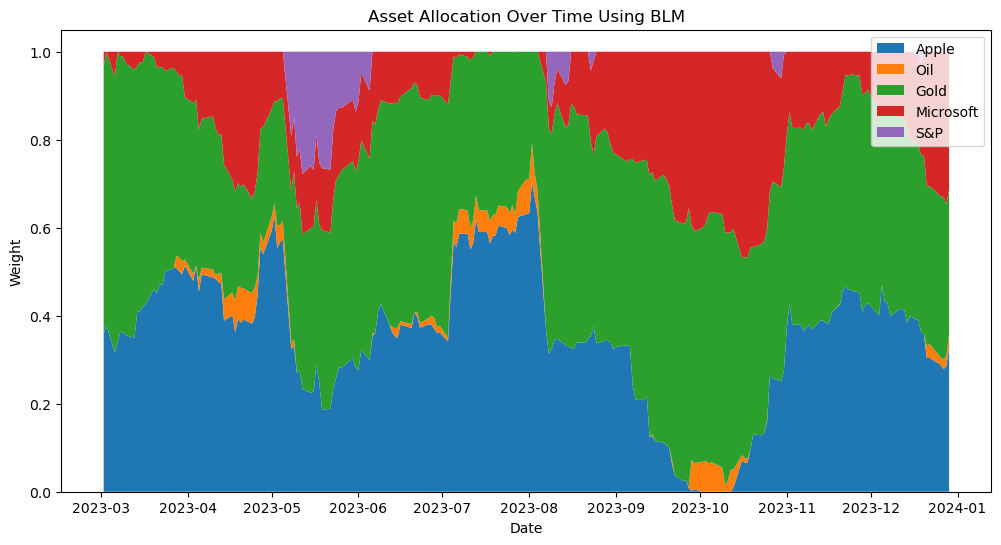

In [6]:
import matplotlib.pyplot as plt

window_size = 40
num_assets = df.shape[1]
weights_over_time = []
label = ['Apple','Oil','Gold','Microsoft','S&P']

for i in range(window_size, len(df)):
    window_returns = df.iloc[i-window_size:i].pct_change().dropna()
    window_sigma = window_returns.cov() * 252  
    window_weights = optimize_sharpe(ER, window_sigma, risk_free_rate)
    weights_over_time.append(window_weights)

weights_df = pd.DataFrame(weights_over_time, columns=df.columns, index=df.index[window_size:])

plt.figure(figsize=(12, 6))
plt.stackplot(weights_df.index, weights_df.T, labels=label)
plt.xlabel('Date')
plt.ylabel('Weight')
plt.title('Asset Allocation Over Time Using BLM')
plt.legend()
plt.show()

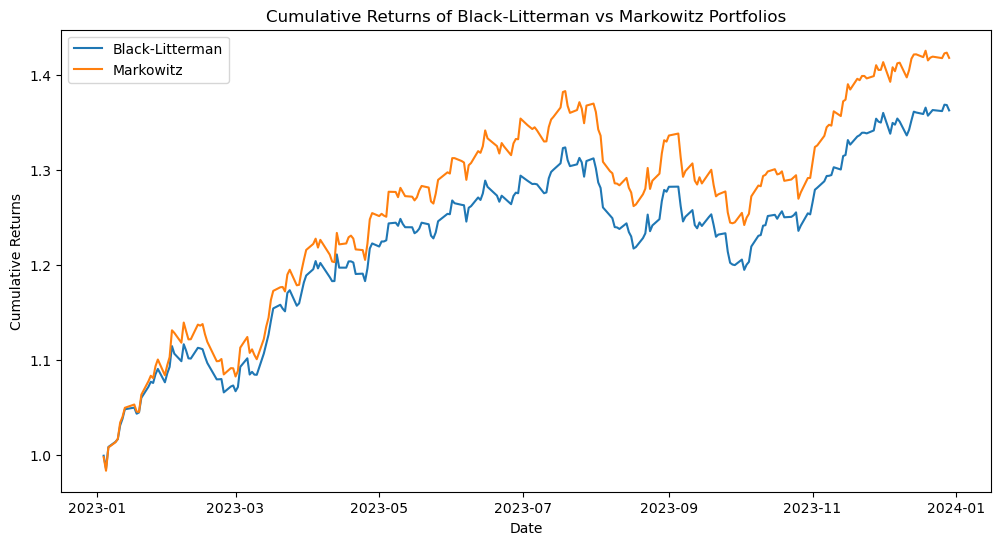

In [7]:
daily_returns = df.pct_change().dropna()

# Calculate daily portfolio returns
blm_portfolio_returns = daily_returns.dot(blm_weights)
markowitz_portfolio_returns = daily_returns.dot(markowitz_weights)

# Compute cumulative returns
blm_cumulative_returns = (1 + blm_portfolio_returns).cumprod()
markowitz_cumulative_returns = (1 + markowitz_portfolio_returns).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(blm_cumulative_returns, label='Black-Litterman')
plt.plot(markowitz_cumulative_returns, label='Markowitz')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns of Black-Litterman vs Markowitz Portfolios')
plt.legend()
plt.show()

# Bonus

In [8]:
df = yf.download(ticker,start='2001-01-01',end='2023-12-31',period='1m')['Adj Close']
df
df.reset_index(inplace=True)

[*********************100%%**********************]  5 of 5 completed


In [9]:
df

,Date,AAPL,CL=F,GC=F,MSFT,^SPX
0,2001-01-02,0.225165,27.200001,268.399994,13.445470,1283.270020
1,2001-01-03,0.247871,27.950001,268.000000,14.859759,1347.560059
2,2001-01-04,0.258278,28.200001,267.299988,15.014754,1333.339966
3,2001-01-05,0.247871,28.000000,268.000000,15.227859,1298.349976
4,2001-01-08,0.250709,27.350000,268.000000,15.169738,1295.859985
...,...,...,...,...,...,...
5784,2023-12-22,193.600006,73.559998,2057.100098,374.579987,4754.629883
5785,2023-12-26,193.050003,75.570000,2058.199951,374.660004,4774.750000
5786,2023-12-27,193.149994,74.110001,2081.899902,374.070007,4781.580078
5787,2023-12-28,193.580002,71.769997,2073.899902,375.279999,4783.350098


In [10]:
# Calculate daily returns
returns = df.iloc[:, 1:].pct_change().dropna()

# Calculate expected returns (mean daily returns)
expected_returns = returns.mean()

# Calculate covariance matrix of returns
covariance_matrix = returns.cov()

# Display expected returns and covariance matrix
expected_returns, covariance_matrix

(AAPL    0.001420
 CL=F   -0.000132
 GC=F    0.000412
 MSFT    0.000741
 ^SPX    0.000302
 dtype: float64,
           AAPL      CL=F          GC=F      MSFT          ^SPX
 AAPL  0.000507  0.000084 -4.403907e-06  0.000215  1.681189e-04
 CL=F  0.000084  0.002587  5.510474e-05  0.000081  8.898186e-05
 GC=F -0.000004  0.000055  1.199583e-04 -0.000004 -5.340683e-07
 MSFT  0.000215  0.000081 -4.160457e-06  0.000331  1.639927e-04
 ^SPX  0.000168  0.000089 -5.340683e-07  0.000164  1.506812e-04)

In [11]:
# from scipy.optimize import minimize

# # Risk-free rate (assuming a small constant value as a placeholder)
# risk_free_rate = 0.02

# # Function to calculate μ* based on the provided formula
# def calculate_mu_star(expected_returns, covariance_matrix, P, Omega, T, risk_free_rate):
#     inv_Omega = np.linalg.inv(Omega)
#     PT = P.T
#     term1 = T * PT @ inv_Omega @ P + np.linalg.inv(covariance_matrix)
#     term2 = np.linalg.inv(covariance_matrix) @ expected_returns + sum([PT @ inv_Omega @ np.array([risk_free_rate]) for _ in range(T)])
#     mu_star = np.linalg.inv(term1) @ term2
#     return mu_star

# # Function to calculate Σ* based on the provided formula
# def calculate_sigma_star(covariance_matrix, P, Omega):
#     PT = P.T
#     inv_Omega = np.linalg.inv(Omega)
#     term = PT @ inv_Omega @ P + np.linalg.inv(covariance_matrix)
#     sigma_star = covariance_matrix + np.linalg.inv(term)
#     return sigma_star

# Placeholder objective function to maximize Sharpe ratio
def objective_function(weights, expected_returns, covariance_matrix, risk_free_rate):
    port_return = np.dot(weights, expected_returns)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    sharpe_ratio = (port_return - risk_free_rate) / port_volatility
    # We want to maximize Sharpe ratio, which is equivalent to minimizing negative Sharpe ratio
    return -sharpe_ratio

# Constraints for optimization (weights sum to 1)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds for weights (no short selling, each weight between 0 and 1)
bounds = tuple((0, 1) for _ in range(len(expected_returns)))

# Initial guess (equal weighting)
initial_weights = np.array(len(expected_returns) * [1. / len(expected_returns)])

# Portfolio optimization
result = minimize(objective_function, initial_weights, args=(expected_returns, covariance_matrix, risk_free_rate),
                  method='SLSQP', bounds=bounds, constraints=constraints)

# Check if the optimization was successful
if result.success:
    optimized_weights = result.x
    optimized_sharpe_ratio = -result.fun
else:
    optimized_weights = None
    optimized_sharpe_ratio = None

optimized_weights, optimized_sharpe_ratio

(array([0., 1., 0., 0., 0.]), -0.3958245663268992)

In [12]:
from scipy.optimize import minimize
# arbitrary
P = np.identity(len(expected_returns))

# Ω is given to be the covariance matrix itself
Omega = covariance_matrix

# T is the sample size - the number of observations in the data frame
T = len(df) - 1  # Subtracting 1 because the first row was dropped (NaNs from pct_change())

# We still need to define the risk-free rate for the Sharpe ratio calculation
# We'll use an annual risk-free rate and divide by the number of trading days to get the daily rate
annual_risk_free_rate = 0.01  # Assuming 1% annual risk-free rate for simplicity
daily_risk_free_rate = annual_risk_free_rate / 252  # Assuming 252 trading days in a year

# Re-run the optimization with the corrected definitions
opt_results = minimize(objective_function, initial_weights, args=(expected_returns, covariance_matrix, daily_risk_free_rate), 
                       method='SLSQP', bounds=bounds, constraints=constraints)

# Check if the optimization was successful and get the results
if opt_results.success:
    optimized_weights = opt_results.x
    optimized_sharpe_ratio = -opt_results.fun
else:
    optimized_weights = None
    optimized_sharpe_ratio = None

optimized_weights, optimized_sharpe_ratio

(array([0.40438533, 0.        , 0.51349826, 0.08211641, 0.        ]),
 0.07112791436451683)

In [13]:
from datetime import timedelta

trading_days_in_year = 252

def rolling_forecast(df, start_date, learning_window_years=5):
    # Define the end date of the learning window as 5 years before the start date
    end_date = start_date - timedelta(days=learning_window_years*365)
    
    # Filter the data frame for the learning window
    learning_window_df = df[(df['Date'] >= end_date) & (df['Date'] < start_date)]
    
    # Calculate returns for the learning window
    learning_returns = learning_window_df.iloc[:, 1:].pct_change().dropna()
    
    # Calculate expected returns and covariance matrix based on the learning window
    learning_expected_returns = learning_returns.mean()
    learning_covariance_matrix = learning_returns.cov()
    
    # Run the optimization with the corrected definitions
    opt_results = minimize(objective_function, initial_weights, args=(learning_expected_returns, learning_covariance_matrix, daily_risk_free_rate), 
                           method='SLSQP', bounds=bounds, constraints=constraints)

    # Return the optimized weights and Sharpe ratio if successful
    if opt_results.success:
        optimized_weights = opt_results.x
        optimized_sharpe_ratio = -opt_results.fun
    else:
        optimized_weights = None
        optimized_sharpe_ratio = None

    return optimized_weights, optimized_sharpe_ratio

# Initialize a dictionary to store the rolling forecast results
rolling_results = {}

learning_window_years = 5
# Start the rolling forecast one month after the first date in the dataset
start_date = df['Date'].min() + timedelta(days=365*learning_window_years)

# End the rolling forecast at the last date in the dataset
end_date = df['Date'].max()

# Perform the rolling forecast in a loop, month by month
current_date = start_date
while current_date <= end_date:
    # Perform the rolling forecast for the current month
    weights, sharpe_ratio = rolling_forecast(df, current_date)
    
    # Store the results in the dictionary
    rolling_results[current_date] = {'weights': weights, 'sharpe_ratio': sharpe_ratio}
    
    # Move to the next month
    current_date += timedelta(days=30)  # Approximate increment, actual calendar dates will vary

list(rolling_results.items())[:5]  # Show the first 5 results for brevity

[(Timestamp('2006-01-01 00:00:00'),
  {'weights': array([2.68558994e-01, 1.25891945e-01, 6.05549061e-01, 9.32413868e-18,
          7.58941521e-18]),
   'sharpe_ratio': 0.10193397782207095}),
 (Timestamp('2006-01-31 00:00:00'),
  {'weights': array([0.24085872, 0.1199698 , 0.63917148, 0.        , 0.        ]),
   'sharpe_ratio': 0.1001755373902987}),
 (Timestamp('2006-03-02 00:00:00'),
  {'weights': array([0.24089985, 0.11008853, 0.64901162, 0.        , 0.        ]),
   'sharpe_ratio': 0.09958352293912813}),
 (Timestamp('2006-04-01 00:00:00'),
  {'weights': array([2.21332902e-01, 1.29343863e-01, 6.49323235e-01, 2.27682456e-18,
          0.00000000e+00]),
   'sharpe_ratio': 0.10103477011851984}),
 (Timestamp('2006-05-01 00:00:00'),
  {'weights': array([2.13614720e-01, 1.18326320e-01, 6.68058959e-01, 0.00000000e+00,
          2.28766658e-17]),
   'sharpe_ratio': 0.10325298070839013})]

In [14]:
def rolling_forecast_optimization(df, initial_date, window_years=5):
    # Convert initial_date to datetime
    initial_date = pd.to_datetime(initial_date)
    
    # Calculate the lookback period (5 years)
    lookback_period = pd.DateOffset(years=window_years)
    
    # Initialize the results list
    forecast_results = []
    
    # Loop through the dataframe month by month starting from initial_date
    while initial_date < df['Date'].iloc[-1]:
        # Determine the start and end of the lookback period
        start_period = initial_date - lookback_period
        end_period = initial_date
        
        # Filter the dataframe to the lookback period
        df_lookback = df[(df['Date'] > start_period) & (df['Date'] <= end_period)]
        
        # Calculate monthly returns for the lookback period
        monthly_returns = df_lookback.set_index('Date').resample('M').last().pct_change().dropna()
        
        # Calculate expected returns and covariance matrix
        expected_returns = monthly_returns.mean()
        covariance_matrix = monthly_returns.cov()
        
        # Run the portfolio optimization
        opt_results = minimize(objective_function, initial_weights, args=(expected_returns, covariance_matrix, daily_risk_free_rate), 
                               method='SLSQP', bounds=bounds, constraints=constraints)

        # If the optimization is successful, store the results
        if opt_results.success:
            optimized_weights = opt_results.x
            optimized_sharpe_ratio = -opt_results.fun
            forecast_results.append((initial_date, optimized_weights, optimized_sharpe_ratio))
        else:
            forecast_results.append((initial_date, None, None))
        
        # Increment initial_date by one month for the next iteration
        initial_date += pd.DateOffset(months=1)
    
    return forecast_results

# Run the rolling forecast optimization
# We start the initial_date five years after the first date in the dataset to have enough data for learning
initial_date = df['Date'].min() + pd.DateOffset(years=5)
rolling_forecast_results = rolling_forecast_optimization(df, initial_date)

rolling_forecast_results[:5]

[(Timestamp('2006-01-02 00:00:00'),
  array([0.17410607, 0.14582965, 0.60191909, 0.0781452 , 0.        ]),
  0.4463121465873047),
 (Timestamp('2006-02-02 00:00:00'),
  array([1.88082827e-01, 1.44469239e-01, 5.89679823e-01, 7.77681101e-02,
         1.20617492e-17]),
  0.48126470052180187),
 (Timestamp('2006-03-02 00:00:00'),
  array([0.14437753, 0.14035464, 0.60812372, 0.10714412, 0.        ]),
  0.46714239513018024),
 (Timestamp('2006-04-02 00:00:00'),
  array([0.13384651, 0.14395009, 0.62168435, 0.10051905, 0.        ]),
  0.4509416259052409),
 (Timestamp('2006-05-02 00:00:00'),
  array([0.17730263, 0.14539147, 0.61117119, 0.0661347 , 0.        ]),
  0.5005937678420787)]

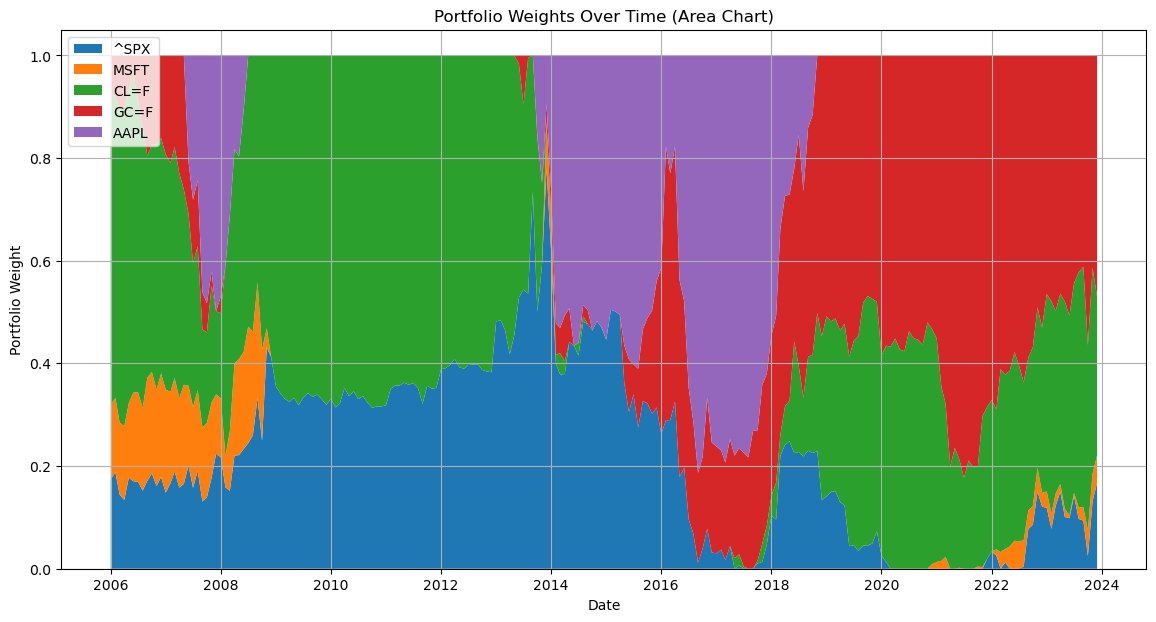

In [18]:
# Rename assets according to the provided list
asset_names = ['^SPX', 'MSFT', 'CL=F', 'GC=F', 'AAPL']

# Plot the portfolio weights over time using an area chart with renamed assets

dates = [item[0] for item in rolling_forecast_results]
weights = np.array([item[1] for item in rolling_forecast_results])

plt.figure(figsize=(14, 7))
plt.stackplot(dates, weights.T, labels=asset_names)
plt.xlabel('Date')
plt.ylabel('Portfolio Weight')
plt.title('Portfolio Weights Over Time (Area Chart)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [19]:
portfolio_returns = np.array([item[2] for item in weights_over_time])

average_return = portfolio_returns.mean()

return_std = portfolio_returns.std()

# Calculate the Sharpe ratio using the average risk-free rate provided earlier
# Since we don't have the exact risk-free rate for each time period, we will use the annualized daily rate
sharpe_ratio = (average_return - daily_risk_free_rate) / return_std

sharpe_ratio

4.50478570483526

In [24]:
# # Calculate the cumulative return of the portfolio over time
# cumulative_returns = np.cumprod(1 + portfolio_returns) - 1

# plt.figure(figsize=(14, 7))
# plt.plot(dates[5:], cumulative_returns, marker='o', linestyle='-', color='b')

# plt.xlabel('Date')
# plt.ylabel('Cumulative Return')
# plt.title('Cumulative Return Over Time')
# plt.grid(True)
# plt.show()

In [ ]:
# returns2 = df2.pct_change().dropna()

# rolling_expected_returns = returns2.rolling(window=252).mean().dropna() * 252  # Annualize the returns
# rolling_covariance = returns2.rolling(window=252).cov().dropna() * 252  # Annualize the covariance

# risk_free_rate = 0.02

# def negative_sharpe_ratio(weights, expected_returns, covariance_matrix, risk_free_rate):
#     port_return = np.dot(weights, expected_returns)
#     port_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
#     return -(port_return - risk_free_rate) / port_volatility

# def optimize_portfolio(date, rolling_expected_returns, rolling_covariance, risk_free_rate):
#     num_assets = len(rolling_expected_returns.columns)
#     expected_returns = rolling_expected_returns.loc[date]
#     covariance_matrix = rolling_covariance.loc[(date,)].values.reshape(num_assets, num_assets)
    
#     constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Weights must sum to 1
#     bounds = tuple((0, 1) for asset in range(num_assets))
#     initial_guess = num_assets * [1. / num_assets,]  # Start with equal weights
    
#     result = minimize(
#         negative_sharpe_ratio, initial_guess,
#         args=(expected_returns, covariance_matrix, risk_free_rate),
#         method='SLSQP', bounds=bounds, constraints=constraints
#     )
    
#     return result.x

# portfolio_weights = {}
# dates = rolling_expected_returns.index[::252]  # Rebalance dates

# for date in dates:
#     portfolio_weights[date] = optimize_portfolio(date, rolling_expected_returns, rolling_covariance, risk_free_rate)

# weights_df2 = pd.DataFrame(portfolio_weights).T

# weights_df2.head()

In [ ]:
# returns2 = df2.pct_change().dropna()
# T = len(returns2)  # Sample size
# Sigma = returns2.cov() * 252  # Annualizing the covariance
# mu = returns2.mean() * 252    # Annualize the returns

# # Define the investor's views (P, Q, and Omega)
# # P Matrix
# P = np.array([
#     [0, 0, 0, 0, 1],   
#     [0, 0, 0, 1, -1]
# ])

# # Q Matrix
# Q = np.array([0.10,  # 10% absolute return for SP
#               0.05]) # 5% outperformance of TSLA over ^SPX

# # Ω matrix
# Omega = np.dot(np.dot(P, Sigma), P.T)
# Omega = np.diag(np.diag(Omega))

# risk_free_rate = .02

# # Define the objective function to minimize (negative Sharpe Ratio)
# def neg_sharpe_ratio(weights, ER, Sigma, risk_free_rate):
#     port_return = np.dot(weights, ER)
#     port_volatility = np.sqrt(np.dot(weights.T, np.dot(Sigma, weights)))
#     return -(port_return - risk_free_rate) / port_volatility

# # Constraints for the optimization (weights sum to 1)
# constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# # Bounds for the weights (no short selling)
# bounds = tuple((0, 1) for _ in range(len(mu)))

# # Initial guess for the weights
# initial_weights = np.array(len(mu) * [1. / len(mu)])

# # Optimization function to find the weights that maximize the Sharpe ratio
# def optimize_weights(ER, Sigma, risk_free_rate, bounds, constraints, initial_weights):
#     result = minimize(neg_sharpe_ratio, initial_weights, args=(ER, Sigma, risk_free_rate),
#                       method='SLSQP', bounds=bounds, constraints=constraints)
#     return result.x

# # Bayesian update of expected returns using the formula provided
# theta_hat = np.linalg.inv(T * np.dot(P.T, np.dot(np.linalg.inv(Omega), P)) + np.linalg.inv(Sigma))
# theta_hat = np.dot(theta_hat, (np.dot(np.linalg.inv(Sigma), mu) + T * np.dot(P.T, np.dot(np.linalg.inv(Omega), Q))))

# # Optimize portfolio using the Bayesian updated expected returns
# optimized_weights = optimize_weights(theta_hat, Sigma, risk_free_rate, bounds, constraints, initial_weights)

# # Output the optimized weights
# print("Optimized weights:", optimized_weights)

In [ ]:
# rolling_window_years = 5
# months_in_year = 12
# rolling_window_size = rolling_window_years * months_in_year

# # Calculate monthly returns
# monthly_returns = df2.resample('M').last().pct_change().dropna()

# # Define the function to optimize the portfolio
# def optimize_portfolio(returns, Sigma, risk_free_rate, P, Q, Omega):
#     def neg_sharpe_ratio(weights, returns, Sigma, risk_free_rate):
#         port_return = np.dot(weights, returns)
#         port_volatility = np.sqrt(np.dot(weights.T, np.dot(Sigma, weights)))
#         return -(port_return - risk_free_rate) / port_volatility

#     # Constraints for the optimization (weights sum to 1, all weights are positive)
#     constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
#     bounds = tuple((0, None) for _ in range(len(returns)))

#     # Initial guess for the weights
#     initial_weights = np.array(len(returns) * [1. / len(returns)])

#     # Optimization
#     result = minimize(neg_sharpe_ratio, initial_weights, args=(returns, Sigma, risk_free_rate),
#                       method='SLSQP', bounds=bounds, constraints=constraints)
#     return result.x if result.success else None

# # P Matrix
# P = np.array([
#     [0, 0, 0, 0, 1],   
#     [0, 0, 0, 1, -1]
# ])

# # Q Matrix
# Q = np.array([0.10,  # 10% absolute return for SP
#               0.05]) # 5% outperformance of TSLA over ^SPX

# # Ω matrix
# Omega = np.dot(np.dot(P, Sigma), P.T)
# Omega = np.diag(np.diag(Omega))


# risk_free_rate = .02

# # Rolling window analysis
# optimized_weights_rolling = []
# dates = []

# for i in range(rolling_window_size, len(monthly_returns)):
#     # Get the rolling window data
#     window_data = monthly_returns.iloc[i - rolling_window_size:i]
    
#     # Calculate Sigma (covariance matrix)
#     Sigma = window_data.cov() * months_in_year

#     # Calculate market equilibrium returns (here we use historical mean returns)
#     pi = window_data.mean() * months_in_year
    
#     # Calculate combined expected returns using Black-Litterman model
#     # You need to calculate theta_hat based on your P, Q, and Omega matrices

#     # Optimize portfolio for the next month
#     next_month = monthly_returns.index[i]
#     weights = optimize_portfolio(pi, Sigma, risk_free_rate, P, Q, Omega)
    
#     if weights is not None:
#         optimized_weights_rolling.append(weights)
#         dates.append(next_month)

# # Convert to DataFrame for analysis
# weights_df2 = pd.DataFrame(optimized_weights_rolling, index=dates, columns=df2.columns)

In [ ]:
# plt.figure(figsize=(12, 6))
# plt.stackplot(weights_df2.index, weights_df2.T, labels=df2.columns)
# plt.xlabel('Date')
# plt.ylabel('Weight')
# plt.title('Asset Allocation Over Time Using BLM')
# plt.legend()
# plt.show()

In [ ]:
# # Calculate daily portfolio returns
# blm_portfolio_returns2 = monthly_returns.dot(blm_weights)
# markowitz_portfolio_returns2 = monthly_returns.dot(markowitz_weights)

# # Compute cumulative returns
# blm_cumulative_returns2 = (1 + blm_portfolio_returns2).cumprod()
# markowitz_cumulative_returns2 = (1 + markowitz_portfolio_returns2).cumprod()

# plt.figure(figsize=(12, 6))
# plt.plot(blm_cumulative_returns2, label='Black-Litterman')
# plt.xlabel('Date')
# plt.ylabel('Cumulative Returns')
# plt.title('Cumulative Returns of Black-Litterman vs Markowitz Portfolios')
# plt.legend()
# plt.show()

# learning the view

In [26]:
# monthly_returns

In [ ]:
# mu_SPX = monthly_returns['^SPX'].mean() * 12  # Annualize the return
# mu_AAPL = monthly_returns['AAPL'].mean() * 12  # Annualize the return
# mu_OIL = monthly_returns['CL=F'].mean() * 12  # Annualize the return
# mu_GLD = monthly_returns['GC=F'].mean() * 12  # Annualize the return
# # mu_MSFT = monthly_returns['MSFT'].mean() * 12 

# Q = np.array([
#     mu_SPX,
#     mu_SPX - mu_AAPL,
#     mu_SPX - mu_OIL,
#     mu_SPX - mu_GLD,
# #     mu_SPX - mu_MSFT
# ])

In [ ]:
# Q = Q.reshape(-1, 1)
# Q

In [ ]:
# monthly_returns = df2.resample('M').last().pct_change().dropna()
# months_in_year = 12
# rolling_window_years = 5
# rolling_window_size = rolling_window_years * months_in_year

# risk_free_rate = .02

# # Define the optimization function to maximize Sharpe ratio
# def optimize_portfolio(ER, Sigma, risk_free_rate, bounds, constraints):
#     def neg_sharpe_ratio(weights, ER, Sigma, risk_free_rate):
#         port_return = np.dot(weights, ER)
#         port_volatility = np.sqrt(np.dot(weights.T, np.dot(Sigma, weights)))
#         return -(port_return - risk_free_rate) / port_volatility

#     initial_guess = np.array([1. / len(ER)] * len(ER))
#     result = minimize(neg_sharpe_ratio, initial_guess, args=(ER, Sigma, risk_free_rate),
#                       method='SLSQP', bounds=bounds, constraints=constraints)
#     return result.x if result.success else None

# # Rolling window analysis
# optimized_weights_rolling = []
# dates = []

# for i in range(rolling_window_size, len(monthly_returns)):
#     # Get the rolling window data
#     window_data = monthly_returns.iloc[i - rolling_window_size:i]
    
#     # Calculate Sigma (covariance matrix) and mu (expected market returns)
#     Sigma = window_data.cov() * months_in_year
#     mu = window_data.mean() * months_in_year
    
#     # Calculate historical mean and standard deviation for the past 12 months
#     historical_data = monthly_returns.iloc[i - months_in_year:i]
#     historical_mu = historical_data.mean()
#     historical_sigma = historical_data.std()

#     # Create the relative performance view against SPX
#     relative_performance_view = np.zeros(len(mu))
#     relative_performance_view[-1] = -1  # Assuming ^SPX is the last column in monthly_returns

#     # Create the views based on analysts' rules (a, b, c)
#     views_a = np.where(monthly_returns.iloc[i] <= historical_mu, 1, -1)
#     views_b = np.where(monthly_returns.iloc[i] <= historical_mu + 2 * historical_sigma, 1, np.where(monthly_returns.iloc[i] == historical_mu + 2 * historical_sigma, 0, -1))
#     views_c = np.where(monthly_returns.iloc[i] <= historical_mu + historical_sigma, 1, np.where(monthly_returns.iloc[i] == historical_mu + historical_sigma, 0, -1))

#     # Combine the views into a single matrix P for this month
#     P = np.vstack([relative_performance_view, views_a, views_b, views_c])
#     Omega = np.dot(np.dot(P, Sigma), P.T)
#     Omega = np.diag(np.diag(Omega))

#     # Calculate the combined expected returns using Black-Litterman model
#     pi = mu  # Define the equilibrium returns, here using the historical mean
#     pi = pi.values.reshape(-1,1)
#     inv_t = np.linalg.inv(tau * Sigma)
#     M_inverse = np.linalg.inv(np.dot(np.dot(P.T, np.linalg.inv(Omega)), P) + inv_t)
#     adj_return = np.dot(M_inverse, np.dot(inv_t, pi) + np.dot(np.dot(P.T, np.linalg.inv(Omega)), Q))

#     # Constraints for the optimization (weights sum to 1, all weights are positive)
#     constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
#     bounds = tuple((0, 1) for _ in range(len(mu)))

#     # Optimize portfolio for the next month
#     weights = optimize_portfolio(adj_return, Sigma, risk_free_rate, bounds, constraints)
#     weights_MK = optimize_portfolio(ER, Sigma, risk_free_rate, bounds, constraints)
    
#     if weights is not None:
#         optimized_weights_rolling.append(weights)
#         dates.append(monthly_returns.index[i])

# # Convert to DataFrame for analysis
# weights_df3 = pd.DataFrame(optimized_weights_rolling, index=dates, columns=df.columns)

In [ ]:
# plt.figure(figsize=(12, 6))
# plt.stackplot(weights_df3.index, weights_df3.T, labels=df.columns)
# plt.xlabel('Date')
# plt.ylabel('Weight')
# plt.title('Asset Allocation Over Time Using BLM')
# plt.legend()
# plt.show()

In [ ]:
# annualized_returns = monthly_returns.mean() * 12
# annualized_covariance = monthly_returns.cov() * 12

# # Risk-free rate (you will need to define this based on current data)
# risk_free_rate = 0.02  # Example risk-free rate

# # Define the objective function to minimize (negative Sharpe Ratio)
# def neg_sharpe_ratio(weights, returns, covariance, risk_free_rate):
#     port_return = np.dot(weights, returns)
#     port_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance, weights)))
#     return -(port_return - risk_free_rate) / port_volatility

# # Constraints for the optimization (weights sum to 1, all weights are positive)
# constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
# bounds = tuple((0, 1) for asset in range(len(annualized_returns)))

# # Initial guess for the weights
# initial_weights = np.array([1. / len(annualized_returns)] * len(annualized_returns))

# # Optimization to find the weights that maximize Sharpe ratio
# result = minimize(neg_sharpe_ratio, initial_weights, args=(annualized_returns, annualized_covariance, risk_free_rate),
#                   method='SLSQP', bounds=bounds, constraints=constraints)

# if not result.success:
#     raise ValueError('Optimization failed')

# # The optimized Markowitz weights
# optimized_markowitz_weights = result.x

# # Display the optimized weights
# optimized_markowitz_weights

In [ ]:
# aligned_returns = monthly_returns.loc[weights_df3.index]

# # Calculate the monthly portfolio returns by multiplying the weights with the returns
# portfolio_monthly_returns = (weights_df3 * aligned_returns).sum(axis=1)

# # Calculate the cumulative return
# portfolio_cumulative_return = (1 + portfolio_monthly_returns).cumprod()

# # Output the cumulative return series
# print(portfolio_cumulative_return)

In [ ]:
# markowitz_cumulative_returns2

In [ ]:
# # blm_portfolio_returns2 = monthly_returns.dot(blm_weights)
# markowitz_portfolio_returns2 = monthly_returns.dot(optimized_markowitz_weights)

# # Compute cumulative returns
# # blm_cumulative_returns2 = (1 + blm_portfolio_returns2).cumprod()
# markowitz_cumulative_returns2 = (1 + markowitz_portfolio_returns2).cumprod()

# plt.figure(figsize=(12, 6))
# plt.plot(portfolio_cumulative_return, label='Black-Litterman')
# plt.plot(markowitz_cumulative_returns2, label='Markowitz')
# plt.xlabel('Date')
# plt.ylabel('Cumulative Returns')
# plt.title('Cumulative Returns of Black-Litterman vs Markowitz Portfolios')
# plt.legend()
# plt.show()

In [ ]:
# markowitz_cumulative_returns2

In [ ]:
# plt.figure(figsize=(12, 6))
# plt.plot(portfolio_cumulative_return, label='Black-Litterman')
# plt.xlabel('Date')
# plt.ylabel('Cumulative Returns')
# plt.title('Cumulative Returns of Black-Litterman vs Markowitz Portfolios')
# plt.legend()
# plt.show()